In [6]:
# ^^^ pyforest auto-imports - don't write above this line
%config IPCompleter.greedy=True

In [7]:
import io
import os
import requests
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas.io.sql
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import AutoDateLocator, AutoDateFormatter, date2num
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import findspark
findspark.init()
import databricks.koalas as ks
from pyspark.sql import SparkSession

#from pyspark.sql import SparkSession
#SPARK_KOALAS_AUTOPATCH=false

from datetime import datetime
from datetime import date #importamos date

from mpl_toolkits.mplot3d import Axes3D

#import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf

#import vaex
#import lux
#import pandas_profiling
#from pandas_profiling import ProfileReport


In [8]:
os.getcwd()

'\\\\172.16.2.166\\Riesgo_Estructural\\analistas\\Danilo_Criollo\\Modelo score micro pn\\Base_Generada_Scoring'

In [9]:
from os import listdir
from os.path import isfile, join
path = r'\\172.16.2.166\Riesgo_Estructural\analistas\Danilo_Criollo\Modelo score micro pn\Base_Generada_Scoring'
os.listdir(path)

['archivo_testeo.xlsx',
 'Base_24316.txt',
 'Base_Cartera_Micro_20210129.txt',
 'Base_Score_Test.rar',
 'Base_Score_Test2.rar',
 'Base_Score_Test_30092021.txt',
 'Base_Score_Test_31082021.txt',
 'Base_Score_Test_31122021.txt',
 'base_scoring.rar',
 'BKT_30092021.xlsx',
 'BKT_30122021.xlsx',
 'BK_Base_.xlsx',
 'BK_Base_24316.xlsx',
 'Clientes_Ruta_16122021_2.xlsx',
 'Diccionario de datos_Riesgo Estructural V2.xlsx',
 'INTEROPERABILIDAD - CATALOGO DE DATOS - LIBRE ACCESO Y CON JUSTIFICACIÓN....xls',
 'PEPRFILES.png',
 'PERFILES.png',
 'Score_negocios_prueba.xlsx',
 'tree.dot']

In [5]:
os.chdir(path)

In [10]:
#df_cliente = pd.read_csv('Clientes_Ruta_16122021_2.txt', sep='~', header='infer',  encoding = 'ISO-8859-1', error_bad_lines=True, low_memory=False)
#df_cliente = pd.read_excel('Clientes_Ruta_16122021_2.xlsx', sheet_name='Base_Negocios')
df_cliente = pd.read_csv('Base_Score_Test_30092021.txt', sep='~', header='infer',  encoding = 'ISO-8859-1', error_bad_lines=True, low_memory=False)
df_cliente.head(2)

ente     CEDULA  nro_operacion    fecha_contabilizacion  mes  anio  \
0   426122.0  100006550      510035898  2016-05-03 00:00:00.000    5  2016   
1  2509294.0  100009406      440018580  2016-03-09 00:00:00.000    3  2016   

   porcentaje_cancelacion  porcentaje_cancelacion_saldo  Constante  \
0                    0.00                          0.00  -2.480754   
1                    0.87                          0.87  -2.480754   

   cliente_nuevo  ...     var14     var15 var16  log_odds  P_malos  \
0            0.0  ... -0.256356  0.611717   0.0 -1.812307  0.14036   
1            0.0  ...  0.000000  0.524902   0.0 -2.616724  0.06807   

   Score_Malos  Score_Buenos  trim(base_scoring.Micro_60)  score_buro  \
0   140.359502           860                        BUENO       958.0   
1    68.069790           932                        BUENO       947.0   

   peor_calificacion  
0                1.0  
1                3.0  

[2 rows x 48 columns]

In [11]:
#os.chdir('../')

In [12]:
df_cliente.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729973 entries, 0 to 729972
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ente                             729966 non-null  float64
 1   CEDULA                           729973 non-null  int64  
 2   nro_operacion                    729973 non-null  int64  
 3   fecha_contabilizacion            729973 non-null  object 
 4   mes                              729973 non-null  int64  
 5   anio                             729973 non-null  int64  
 6   porcentaje_cancelacion           729973 non-null  float64
 7   porcentaje_cancelacion_saldo     729973 non-null  float64
 8   Constante                        729973 non-null  float64
 9   cliente_nuevo                    728142 non-null  float64
 10  des_estado_civil                 729963 non-null  object 
 11  des_sector                       729494 non-null  object 
 12  de

In [13]:
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 1000)

In [14]:
df_cliente.rename(columns = {'trim(base_scoring.Micro_60)':'Micro_60'}, inplace = True)

In [15]:
#df_cliente.head(2)

In [16]:
#df_cliente['Micro_60'].unique()
def Micro_60_predecidos(row):
    if row['Score_Buenos'] < 523:
        return 'MALO'
    elif row['Score_Buenos'] >= 523 :
        return 'BUENO'
    else:
        return 'na'

df_cliente['Micro_60_predecidos'] = df_cliente.apply(Micro_60_predecidos, axis=1)
pd.crosstab(df_cliente['Micro_60_predecidos'],df_cliente['Micro_60'], margins=True)

Micro_60              BUENO    MALO     All
Micro_60_predecidos                        
BUENO                411588   92099  503687
MALO                  80748  145538  226286
All                  492336  237637  729973

In [17]:
df_cliente['P_buenos']= 1- df_cliente['P_malos']

In [18]:
df_cliente['ODDS'] = np.exp(df_cliente['log_odds'])

In [19]:
df_cliente['ODDS_ODDS_1'] = df_cliente['ODDS'] / (1+ df_cliente['ODDS'])

In [20]:
df_cliente['p'] = np.exp(df_cliente['log_odds'])/ (1+np.exp( df_cliente['log_odds']))

In [21]:
df_cliente['p1'] = 1/ (1+np.exp(- df_cliente['log_odds']))

In [22]:
df_cliente.head(2)

ente     CEDULA  nro_operacion    fecha_contabilizacion  mes  anio  \
0   426122.0  100006550      510035898  2016-05-03 00:00:00.000    5  2016   
1  2509294.0  100009406      440018580  2016-03-09 00:00:00.000    3  2016   

   porcentaje_cancelacion  porcentaje_cancelacion_saldo  Constante  \
0                    0.00                          0.00  -2.480754   
1                    0.87                          0.87  -2.480754   

   cliente_nuevo des_estado_civil     des_sector des_op_sector_bnf  \
0            0.0           CASADO  SECTOR URBANO          PECUARIO   
1            0.0           CASADO  SECTOR URBANO          AGRICOLA   

      des_zonal des_forma_pago   ing_gas  activos_pasivos  \
0  ZONAL CUENCA          ANUAL  6.421077         0.000000   
1  ZONAL CUENCA      SEMESTRAL  2.641717       198.666667   

   CUOTA_ESTIMADA_BURO  ENDEUDAMIENTO_PROMEDIO  ventas_netas_balances  \
0               783.96                  0.0000                81300.0   
1               332.46                895.4533                 3300.0   

   monto_aprobado  SUELDO  periodos_plazo  PLAZO_MESES  \
0         15000.0  2000.0               2         24.0   
1          3000.0  1000.0               8         48.0   

   mayorplazovencidohistóricototal  Var1  Var2      Var3      Var4      var5  \
0                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   
1                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   

       var6      var7      var8      var9     var10     var11     var12  \
0 -0.298471 -0.327237  0.008148  0.000000  1.103768  0.000000  0.080233   
1 -0.252034 -0.327237  0.008148  0.257294  0.070112  0.039883 -0.159057   

      var13     var14     var15  var16  log_odds  P_malos  Score_Malos  \
0  0.044626 -0.256356  0.611717    0.0 -1.812307  0.14036   140.359502   
1  0.000000  0.000000  0.524902    0.0 -2.616724  0.06807    68.069790   

   Score_Buenos Micro_60  score_buro  peor_calificacion Micro_60_predecidos  \
0           860    BUENO       958.0                1.0               BUENO   
1           932    BUENO       947.0                3.0               BUENO   

   P_buenos      ODDS  ODDS_ODDS_1        p       p1  
0   0.85964  0.163277      0.14036  0.14036  0.14036  
1   0.93193  0.073042      0.06807  0.06807  0.06807

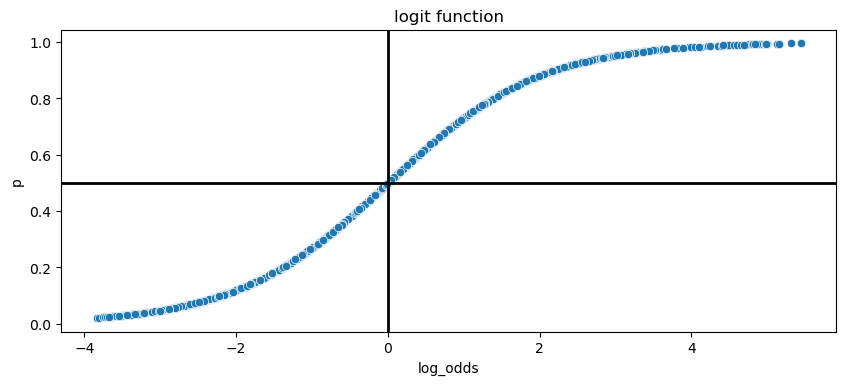

In [23]:
fig, ax =plt.subplots(figsize=(10,4), dpi=100)
sns.scatterplot(y = 'p', x = "log_odds", data = df_cliente)
plt.title('logit function')
plt.axhline(0.5, linewidth=2, color='black')
plt.axvline(0, linewidth=2, color='black')
plt.show() 

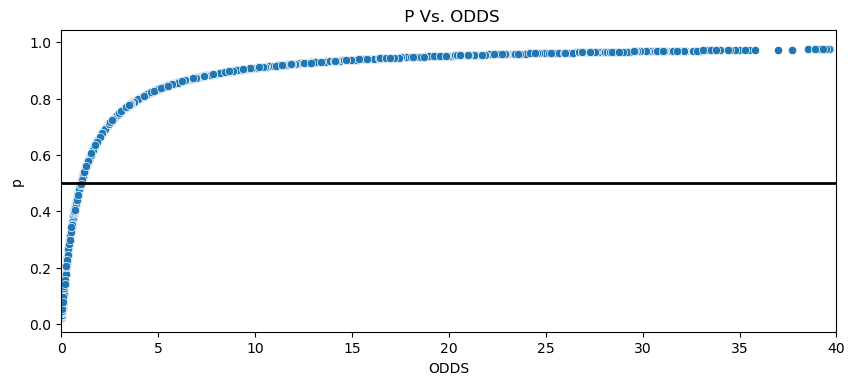

In [24]:
fig, ax = plt.subplots(figsize=(10,4), dpi=100)
#fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5), dpi=100)
sns.scatterplot(y = "p", x = 'ODDS' , data = df_cliente)
plt.title(' P Vs. ODDS')
#ax.plt.set_xticks([0, 1,2,3,4,5,6,7,8,9,10])
plt.axhline(0.5, linewidth=2, color='black')
plt.xlim(0,40)
plt.show() 

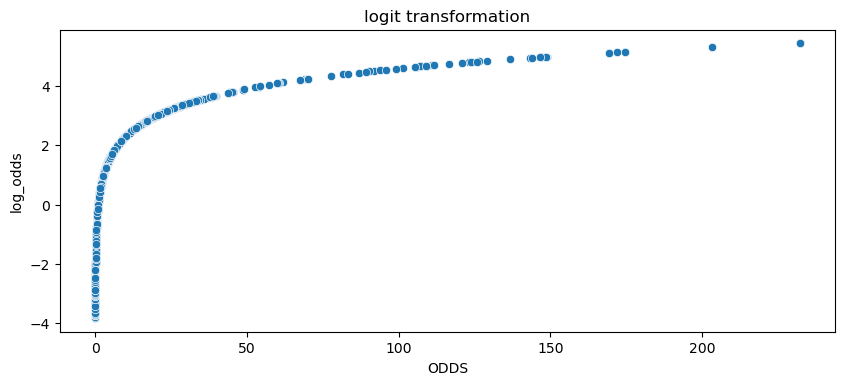

In [25]:
fig, ax =plt.subplots(figsize=(10,4), dpi=100)
sns.scatterplot(y = 'log_odds', x = "ODDS", data = df_cliente)
#sns.scatterplot(y = 'ODDS', x = "log_odds", data = df_cliente)
plt.title('logit transformation')
#plt.legend()
#axes.legend(loc=2)
plt.show()  

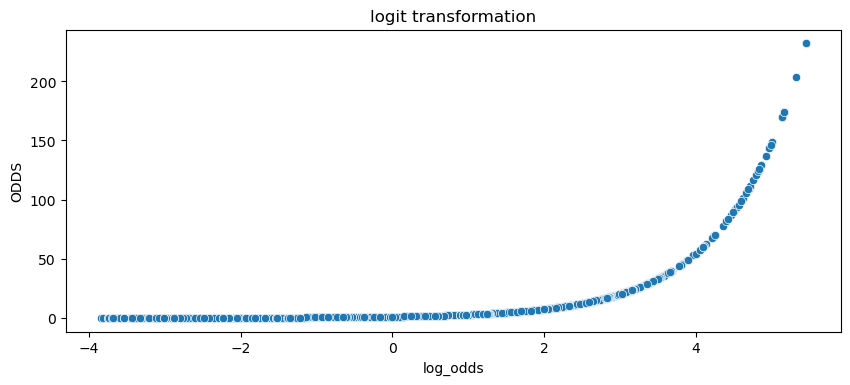

In [26]:
fig, ax =plt.subplots(figsize=(10,4), dpi=100)
sns.scatterplot(y = 'ODDS', x = "log_odds", data = df_cliente)
plt.title('logit transformation')
#plt.legend()
#axes.legend(loc=2)
plt.show() 

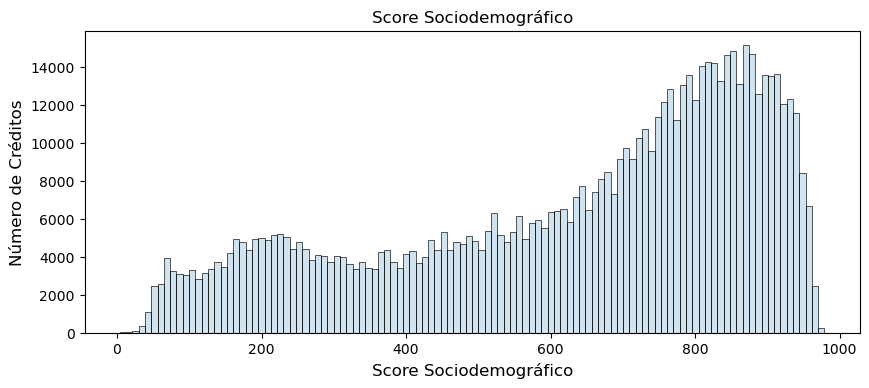

In [27]:
fig, ax =plt.subplots(figsize=(10,4), dpi=100)
sns.histplot(data = df_cliente,x = 'Score_Buenos',alpha = .2 )
ax.set_title('Score Sociodemográfico', fontsize=12)
ax.set_xlabel('Score Sociodemográfico', fontsize=12)
ax.set_ylabel('Número de Créditos', fontsize=12)
#ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

In [28]:
#df_cliente.rename(columns = {'Micro_60_predecidos':'Micro_60'}, inplace = True)
#df_cliente.head(2)

In [29]:
df_cliente['Micro_60'].unique()

array(['BUENO', 'MALO'], dtype=object)

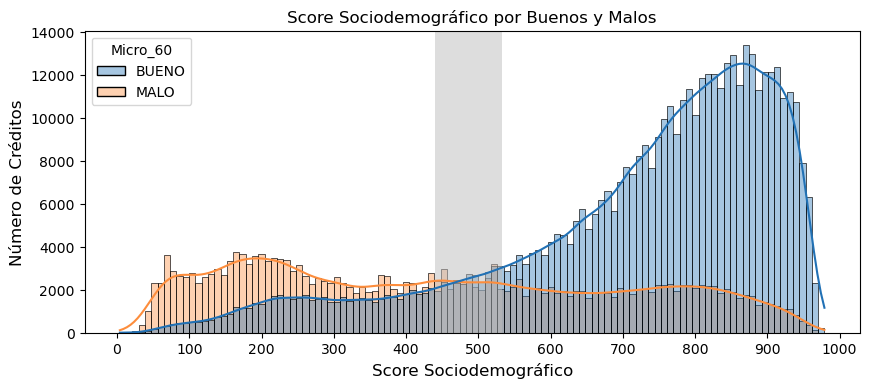

In [30]:
fig, ax =plt.subplots(figsize=(10,4), dpi=100)
palette = {"BUENO":"#2171b5","MALO":"#fd8d3c", "NUEVO":"#74c476"}
sns.histplot(data = df_cliente,x = 'Score_Buenos',alpha = .4,hue = 'Micro_60',kde=True ,  palette = palette)
label=('Score Socio Demografico - (IRB)')
ax.set_xlabel('Score Sociodemográfico', fontsize=12)
ax.set_ylabel('Número de Créditos', fontsize=12)
ax.set_title('Score Sociodemográfico por Buenos y Malos', fontsize=12)
ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
#plt.legend(loc='upper left')
#ax.axvspan(381, 523, facecolor='#d4b9da', alpha=0.5)
ax.axvspan(440, 533, facecolor='#bdbdbd', alpha=0.5)
plt.show()

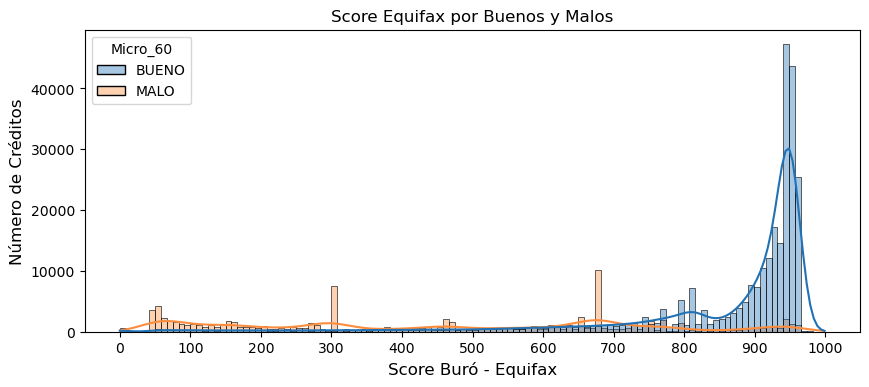

In [31]:
#order = ['A1','A2','A3','B1','B2','C1','C2','D','E']
fig, ax =plt.subplots(figsize=(10,4), dpi=100)
palette = {"BUENO":"#2171b5","MALO":"#fd8d3c", "NUEVO":"#74c476"}
sns.histplot(data = df_cliente,x = 'score_buro',alpha = .4,hue = 'Micro_60', kde=True,  palette = palette )
label=('Score Equifax')
ax.set_xlabel('Score Buró - Equifax', fontsize=12)
ax.set_ylabel('Número de Créditos', fontsize=12)
ax.set_title('Score Equifax por Buenos y Malos', fontsize=12)
ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.show()

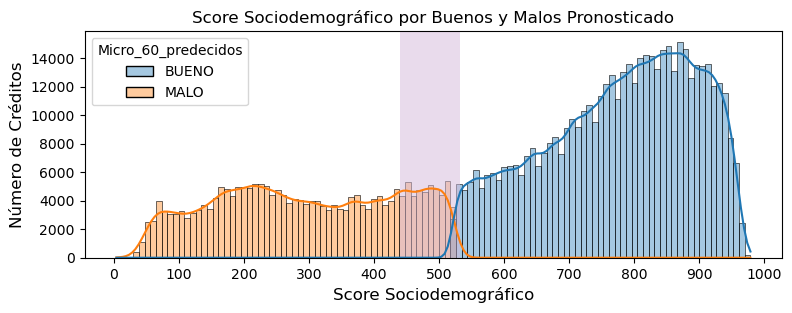

In [32]:
#hue_order =['BUENO', 'MALO'],
#palette = {"BUENO":"#2171b5","MALO ":"#d7301f"}
fig, ax =plt.subplots(figsize=(9,3), dpi=100)
sns.histplot(data = df_cliente,x = 'Score_Buenos',alpha = .4,hue = 'Micro_60_predecidos',hue_order =['BUENO', 'MALO'] ,kde=True )
label=('Score Socio Demografico - (IRB)')
ax.set_xlabel('Score Sociodemográfico', fontsize=12)
ax.set_ylabel('Número de Créditos', fontsize=12)
ax.set_title('Score Sociodemográfico por Buenos y Malos Pronosticado', fontsize=12)
ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
ax.axvspan(440, 533, facecolor='#d4b9da', alpha=0.5)
plt.show()

In [33]:
df_cliente.rename(columns = {'peor_calif':'peor_calificacion'}, inplace = True)
categorizar =  {"peor_calificacion":{1:"A1", 2:"A2", 3:"A3",4:"B1",5:"B2", 6:"C1",7:"C2", 8:"D", 9:"E"}
               }
# bandera_Demanda_Judicial
df_cliente = df_cliente.replace(categorizar)

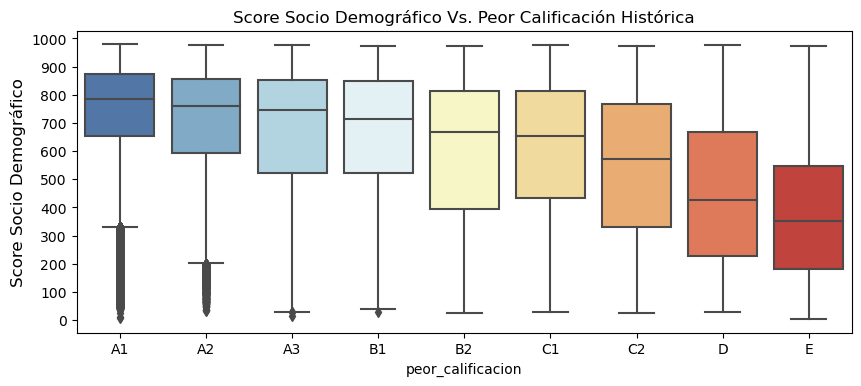

In [34]:
#RdYGn
data= df_cliente
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,4), dpi=100)
sns.boxplot(x = 'peor_calificacion', y ='Score_Buenos', data = df_cliente, order = ['A1','A2','A3','B1','B2','C1','C2','D','E'], palette = 'RdYlBu_r' )
plt.title('Score Socio Demográfico Vs. Peor Calificación Histórica')
axes.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
axes.set_ylabel('Score Socio Demográfico', fontsize=12)
#plt.axhline(500, linewidth=2, color='g')
#plt.legend()
plt.show()

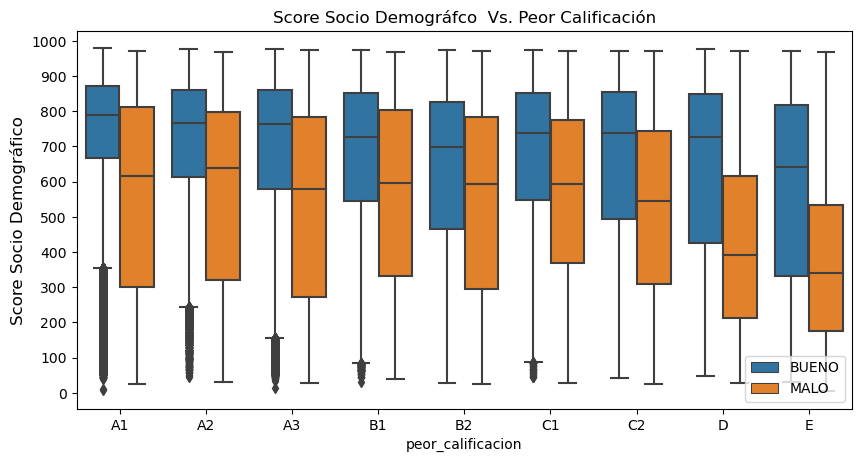

In [35]:
#https://colorbrewer2.org/#type=sequential&scheme=Blues&n=9
#sns.color_palette("Set1", as_cmap=True)
#, hue = "Micro_60", hue_order =['BUENO', 'MALO'],
#palette = {"BUENO":"#2171b5","MALO ":"#d7301f"}
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,5), dpi=100)
sns.boxplot(x = 'peor_calificacion', y ='Score_Buenos', data = df_cliente, hue='Micro_60',hue_order =['BUENO','MALO' ],order = ['A1','A2','A3','B1','B2','C1','C2','D','E'])
plt.title('Score Socio Demográfco  Vs. Peor Calificación')
axes.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
#plt.axhline(500, linewidth=2, color='r')
axes.set_ylabel('Score Socio Demográfico', fontsize=12)
plt.legend(borderaxespad=1,title='Target')
axes.legend(loc=4)
plt.show()

In [36]:
def Micro_60_predecidos(row):
    if row['Score_Buenos'] < 540:
        return 'MALO_P'
    elif row['Score_Buenos'] >= 540 :
        return 'BUENO_P'
    else:
        return 'na'

df_cliente['Micro_60_predecidos'] = df_cliente.apply(Micro_60_predecidos, axis=1)
pd.crosstab(df_cliente['Micro_60_predecidos'],df_cliente['Micro_60'], margins=True)

Micro_60              BUENO    MALO     All
Micro_60_predecidos                        
BUENO_P              405809   87684  493493
MALO_P                86527  149953  236480
All                  492336  237637  729973

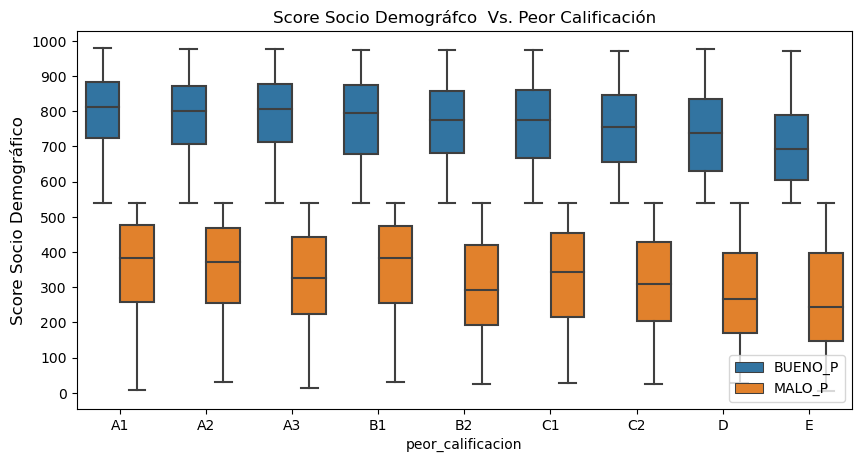

In [37]:
#https://colorbrewer2.org/#type=sequential&scheme=Blues&n=9
#sns.color_palette("Set1", as_cmap=True)
#, hue = "Micro_60", hue_order =['BUENO', 'MALO'],
#palette = {"BUENO":"#2171b5","MALO ":"#d7301f"}
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,5), dpi=100)
sns.boxplot(x = 'peor_calificacion', y ='Score_Buenos', data = df_cliente, hue='Micro_60_predecidos',hue_order =['BUENO_P','MALO_P' ],order = ['A1','A2','A3','B1','B2','C1','C2','D','E'])
plt.title('Score Socio Demográfco  Vs. Peor Calificación')
axes.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
#plt.axhline(500, linewidth=2, color='r')
axes.set_ylabel('Score Socio Demográfico', fontsize=12)
plt.legend(borderaxespad=1,title='Target')
axes.legend(loc=4)
plt.show()

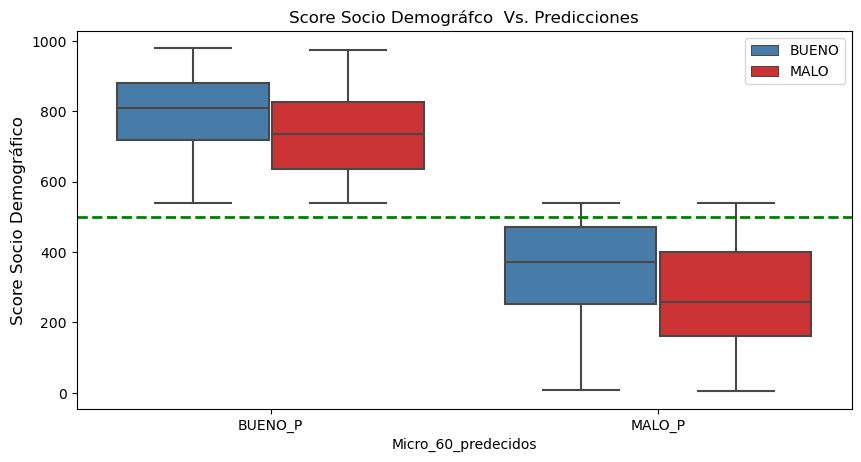

In [38]:
#sns.color_palette("Set1", as_cmap=True)
#, hue = "Micro_60", hue_order =['BUENO', 'MALO'],
palette = {"BUENO":"#377eb8","MALO":"#e41a1c"}
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,5), dpi=100)
sns.boxplot(x = 'Micro_60_predecidos', y ='Score_Buenos', data = df_cliente, hue='Micro_60', hue_order =['BUENO','MALO', ],dodge=True,  palette=palette)
plt.title('Score Socio Demográfco  Vs. Predicciones')
#axes.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.axhline(500, linewidth=2, color='g', ls='--')
axes.set_ylabel('Score Socio Demográfico', fontsize=12)
plt.legend()
plt.show()

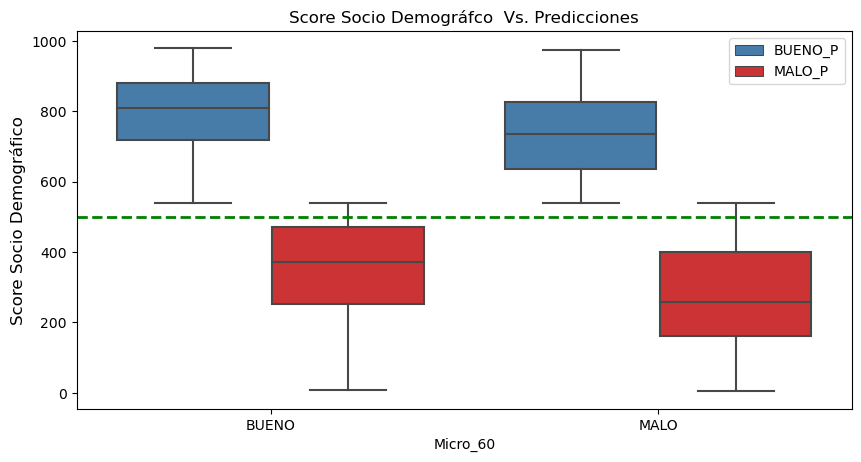

In [39]:
palette = {"BUENO_P":"#377eb8","MALO_P":"#e41a1c"}
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,5), dpi=100)
sns.boxplot(x = 'Micro_60', y ='Score_Buenos', data = df_cliente, hue='Micro_60_predecidos', hue_order =['BUENO_P','MALO_P', ],dodge=True,  palette=palette)
plt.title('Score Socio Demográfco  Vs. Predicciones')
#axes.set_yticks([0,100,200,300,400,500,600,700,800,900,1000])
plt.axhline(500, linewidth=2, color='g', ls='--')
axes.set_ylabel('Score Socio Demográfico', fontsize=12)
plt.legend()
plt.show()

In [40]:
#df_cliente.groupby('Micro_60').describe().reset_index().pivot(index='Micro_60', values='Score_Buenos',, columns='level_1')
df_cliente.groupby('Micro_60')['Score_Buenos'].describe()

count        mean         std  min    25%    50%    75%    max
Micro_60                                                                   
BUENO     492336.0  716.065575  200.214965  8.0  623.0  774.0  866.0  979.0
MALO      237637.0  445.375055  256.566933  4.0  215.0  427.0  665.0  975.0

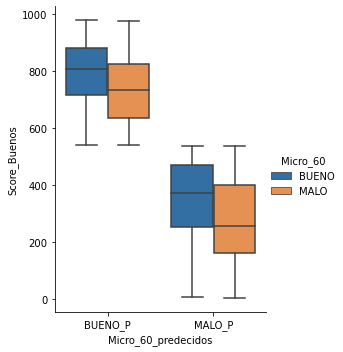

In [41]:
palette = {"BUENO":"#2171b5","MALO":"#fd8d3c", "NUEVO":"#74c476"}
#sns.catplot(x="Micro_60_predecidos", y="Score_Buenos",hue="Micro_60", col="cliente_nuevo_buro",data=df_cliente, kind="box",height=5,aspect=.8, palette=palette )
sns.catplot(x="Micro_60_predecidos", y="Score_Buenos",hue="Micro_60",data=df_cliente, kind="box",height=5,aspect=.8, palette=palette )

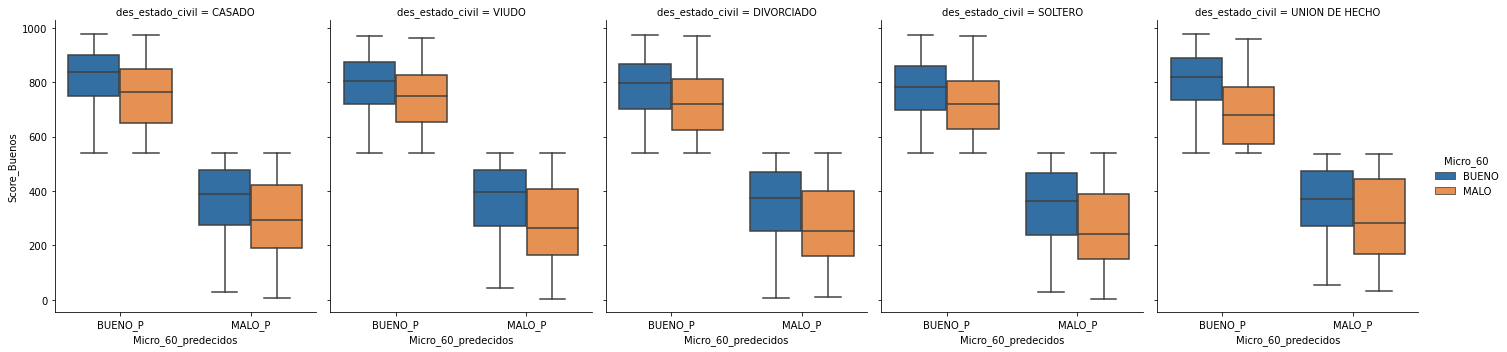

In [42]:
palette = {"BUENO":"#2171b5","MALO":"#fd8d3c", "NUEVO":"#74c476"}
sns.catplot(x="Micro_60_predecidos", y="Score_Buenos",hue="Micro_60", col="des_estado_civil",data=df_cliente, kind="box",height=5,aspect=.8, palette=palette )

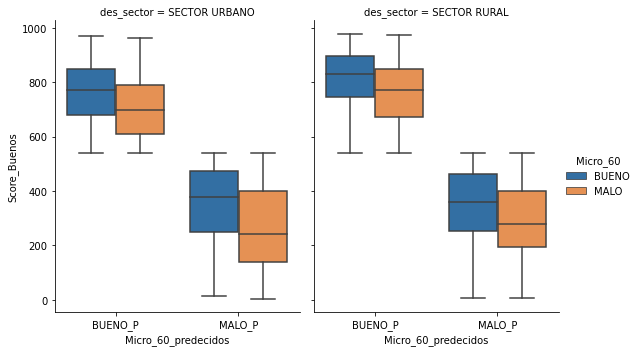

In [43]:
palette = {"BUENO":"#2171b5","MALO":"#fd8d3c", "NUEVO":"#74c476"}
sns.catplot(x="Micro_60_predecidos", y="Score_Buenos",hue="Micro_60", col="des_sector",data=df_cliente, kind="box",height=5,aspect=.8, palette=palette )

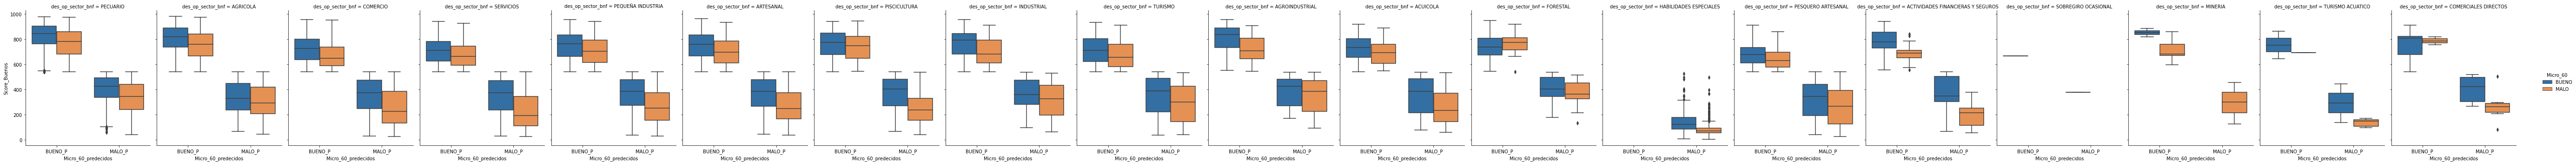

In [44]:
palette = {"BUENO":"#2171b5","MALO":"#fd8d3c", "NUEVO":"#74c476"}
sns.catplot(x="Micro_60_predecidos", y="Score_Buenos",hue="Micro_60", col="des_op_sector_bnf",data=df_cliente, kind="box",height=5,aspect=.8, palette=palette )

# Importar Archivo para Backtest

In [45]:
df_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729973 entries, 0 to 729972
Data columns (total 54 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ente                             729966 non-null  float64
 1   CEDULA                           729973 non-null  int64  
 2   nro_operacion                    729973 non-null  int64  
 3   fecha_contabilizacion            729973 non-null  object 
 4   mes                              729973 non-null  int64  
 5   anio                             729973 non-null  int64  
 6   porcentaje_cancelacion           729973 non-null  float64
 7   porcentaje_cancelacion_saldo     729973 non-null  float64
 8   Constante                        729973 non-null  float64
 9   cliente_nuevo                    728142 non-null  float64
 10  des_estado_civil                 729963 non-null  object 
 11  des_sector                       729494 non-null  object 
 12  de

In [46]:
from os import listdir
from os.path import isfile, join
path = r'\\172.16.2.166\Riesgo_Estructural\analistas\Danilo_Criollo\Modelo score micro pn\Base_Generada_Scoring'
os.listdir(path)

['archivo_testeo.xlsx',
 'Base_24316.txt',
 'Base_Cartera_Micro_20210129.txt',
 'Base_Score_Test.rar',
 'Base_Score_Test2.rar',
 'Base_Score_Test_30092021.txt',
 'Base_Score_Test_31082021.txt',
 'Base_Score_Test_31122021.txt',
 'base_scoring.rar',
 'BKT_30092021.xlsx',
 'BKT_30122021.xlsx',
 'BK_Base_.xlsx',
 'BK_Base_24316.xlsx',
 'Clientes_Ruta_16122021_2.xlsx',
 'Diccionario de datos_Riesgo Estructural V2.xlsx',
 'INTEROPERABILIDAD - CATALOGO DE DATOS - LIBRE ACCESO Y CON JUSTIFICACIÓN....xls',
 'PEPRFILES.png',
 'PERFILES.png',
 'Score_negocios_prueba.xlsx',
 'tree.dot']

In [82]:
df_cliente = pd.read_csv('Base_Score_Test_30092021.txt', sep='~', header='infer',  encoding = 'ISO-8859-1', error_bad_lines=True, low_memory=False)
df_cliente.head(2)

ente     CEDULA  nro_operacion    fecha_contabilizacion  mes  anio  \
0   426122.0  100006550      510035898  2016-05-03 00:00:00.000    5  2016   
1  2509294.0  100009406      440018580  2016-03-09 00:00:00.000    3  2016   

   porcentaje_cancelacion  porcentaje_cancelacion_saldo  Constante  \
0                    0.00                          0.00  -2.480754   
1                    0.87                          0.87  -2.480754   

   cliente_nuevo des_estado_civil     des_sector des_op_sector_bnf  \
0            0.0           CASADO  SECTOR URBANO          PECUARIO   
1            0.0           CASADO  SECTOR URBANO          AGRICOLA   

      des_zonal des_forma_pago   ing_gas  activos_pasivos  \
0  ZONAL CUENCA          ANUAL  6.421077         0.000000   
1  ZONAL CUENCA      SEMESTRAL  2.641717       198.666667   

   CUOTA_ESTIMADA_BURO  ENDEUDAMIENTO_PROMEDIO  ventas_netas_balances  \
0               783.96                  0.0000                81300.0   
1               332.46                895.4533                 3300.0   

   monto_aprobado  SUELDO  periodos_plazo  PLAZO_MESES  \
0         15000.0  2000.0               2         24.0   
1          3000.0  1000.0               8         48.0   

   mayorplazovencidohistóricototal  Var1  Var2      Var3      Var4      var5  \
0                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   
1                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   

       var6      var7      var8      var9     var10     var11     var12  \
0 -0.298471 -0.327237  0.008148  0.000000  1.103768  0.000000  0.080233   
1 -0.252034 -0.327237  0.008148  0.257294  0.070112  0.039883 -0.159057   

      var13     var14     var15  var16  log_odds  P_malos  Score_Malos  \
0  0.044626 -0.256356  0.611717    0.0 -1.812307  0.14036   140.359502   
1  0.000000  0.000000  0.524902    0.0 -2.616724  0.06807    68.069790   

   Score_Buenos trim(base_scoring.Micro_60)  score_buro  peor_calificacion  
0           860                       BUENO       958.0                1.0  
1           932                       BUENO       947.0                3.0

In [83]:
df_cliente.rename(columns = {'trim(base_scoring.Micro_60)':'Micro_60'}, inplace = True)
df_cliente.rename(columns = {'mayorplazovencidohist�ricototal':'mpvht'}, inplace = True)

In [84]:
df_cliente.head(2)

ente     CEDULA  nro_operacion    fecha_contabilizacion  mes  anio  \
0   426122.0  100006550      510035898  2016-05-03 00:00:00.000    5  2016   
1  2509294.0  100009406      440018580  2016-03-09 00:00:00.000    3  2016   

   porcentaje_cancelacion  porcentaje_cancelacion_saldo  Constante  \
0                    0.00                          0.00  -2.480754   
1                    0.87                          0.87  -2.480754   

   cliente_nuevo des_estado_civil     des_sector des_op_sector_bnf  \
0            0.0           CASADO  SECTOR URBANO          PECUARIO   
1            0.0           CASADO  SECTOR URBANO          AGRICOLA   

      des_zonal des_forma_pago   ing_gas  activos_pasivos  \
0  ZONAL CUENCA          ANUAL  6.421077         0.000000   
1  ZONAL CUENCA      SEMESTRAL  2.641717       198.666667   

   CUOTA_ESTIMADA_BURO  ENDEUDAMIENTO_PROMEDIO  ventas_netas_balances  \
0               783.96                  0.0000                81300.0   
1               332.46                895.4533                 3300.0   

   monto_aprobado  SUELDO  periodos_plazo  PLAZO_MESES  \
0         15000.0  2000.0               2         24.0   
1          3000.0  1000.0               8         48.0   

   mayorplazovencidohistóricototal  Var1  Var2      Var3      Var4      var5  \
0                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   
1                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   

       var6      var7      var8      var9     var10     var11     var12  \
0 -0.298471 -0.327237  0.008148  0.000000  1.103768  0.000000  0.080233   
1 -0.252034 -0.327237  0.008148  0.257294  0.070112  0.039883 -0.159057   

      var13     var14     var15  var16  log_odds  P_malos  Score_Malos  \
0  0.044626 -0.256356  0.611717    0.0 -1.812307  0.14036   140.359502   
1  0.000000  0.000000  0.524902    0.0 -2.616724  0.06807    68.069790   

   Score_Buenos Micro_60  score_buro  peor_calificacion  
0           860    BUENO       958.0                1.0  
1           932    BUENO       947.0                3.0

# Madurez

In [85]:
#df_cliente['porcentaje_cancelacion'].sort_values(), df_cliente['porcentaje_cancelacion_saldo'].sort_values()
df_cliente['porcentaje_cancelacion'].describe(),df_cliente['porcentaje_cancelacion_saldo'].describe()

(count    729973.000000
 mean          0.444202
 std           0.345523
 min           0.000000
 25%           0.050000
 50%           0.500000
 75%           0.750000
 max           1.000000
 Name: porcentaje_cancelacion, dtype: float64,
 count    729973.000000
 mean          0.481102
 std           0.356818
 min           0.000000
 25%           0.120000
 50%           0.500000
 75%           0.830000
 max           1.000000
 Name: porcentaje_cancelacion_saldo, dtype: float64)

In [86]:
df_cliente[['periodos_plazo','PLAZO_MESES']].describe()

periodos_plazo    PLAZO_MESES
count   729973.000000  729971.000000
mean        18.031275      38.942335
std         18.267205      21.783437
min          1.000000       0.000000
25%          4.000000      24.000000
50%         10.000000      36.000000
75%         34.000000      60.000000
max        240.000000     720.000000

In [87]:
df_cartera_madura = df_cliente.loc[(df_cliente.porcentaje_cancelacion_saldo >= 0.5) ,:]

In [88]:
df_cartera_madura.shape

(380382, 48)

In [89]:
#print(df_cartera_madura['Score_Buenos'].min(),df_cartera_madura['Score_Buenos'].max())

In [90]:
df_cliente = df_cartera_madura

In [91]:
df_cliente['Percentile'] = df_cliente['Score_Buenos'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [92]:
df_cliente['Score_Buenos'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

0.0      4.0
0.1    231.0
0.2    401.0
0.3    522.0
0.4    619.0
0.5    702.0
0.6    766.0
0.7    816.0
0.8    860.0
0.9    908.0
1.0    979.0
Name: Score_Buenos, dtype: float64

In [93]:
df_cliente['Bucket'] = np.round(df_cliente.Score_Buenos.rank(pct = True), decimals=1)
df_cliente['Bucket'].value_counts()

0.7    38607
0.9    38386
0.5    38245
0.4    38232
0.2    38087
0.1    37953
0.3    37910
0.8    37690
0.6    37409
0.0    19065
1.0    18798
Name: Bucket, dtype: int64

In [94]:
df_cliente['rango']= pd.qcut(df_cliente['Score_Buenos'], 10)
df_cliente['rango'].value_counts()

(860.0, 908.0]    38361
(401.0, 522.0]    38329
(3.999, 231.0]    38303
(766.0, 816.0]    38192
(619.0, 702.0]    38155
(702.0, 766.0]    38152
(522.0, 619.0]    37913
(816.0, 860.0]    37806
(231.0, 401.0]    37790
(908.0, 979.0]    37381
Name: rango, dtype: int64

In [95]:
df_cliente['rango_20']= pd.qcut(df_cliente['Score_Buenos'], 20)
df_cliente['rango_20'].value_counts()

(860.0, 883.0]    19396
(466.0, 522.0]    19317
(662.0, 702.0]    19243
(145.0, 231.0]    19238
(792.0, 816.0]    19208
(736.0, 766.0]    19150
(838.0, 860.0]    19132
(3.999, 145.0]    19065
(401.0, 466.0]    19012
(702.0, 736.0]    19002
(766.0, 792.0]    18984
(522.0, 572.0]    18965
(883.0, 908.0]    18965
(572.0, 619.0]    18948
(619.0, 662.0]    18912
(231.0, 318.0]    18903
(318.0, 401.0]    18887
(933.0, 979.0]    18798
(816.0, 838.0]    18674
(908.0, 933.0]    18583
Name: rango_20, dtype: int64

In [96]:
df_cliente['rango_perfil_8']= pd.qcut(df_cliente['Score_Buenos'], 8)
df_cliente['rango_perfil_8'].value_counts()

(838.0, 895.0]    47929
(466.0, 596.0]    47777
(3.999, 273.0]    47674
(596.0, 702.0]    47608
(702.0, 779.0]    47576
(779.0, 838.0]    47442
(273.0, 466.0]    47431
(895.0, 979.0]    46945
Name: rango_perfil_8, dtype: int64

In [97]:
df_cliente['rango_perfil_9']= pd.qcut(df_cliente['Score_Buenos'], 9)
df_cliente['rango_perfil_9'].value_counts()

(850.0, 902.0]    42629
(434.0, 556.0]    42610
(3.999, 248.0]    42320
(556.0, 658.0]    42303
(248.0, 434.0]    42235
(658.0, 740.0]    42226
(740.0, 800.0]    42166
(800.0, 850.0]    42010
(902.0, 979.0]    41883
Name: rango_perfil_9, dtype: int64

In [98]:
df_cliente['rango_perfil_20']= pd.qcut(df_cliente['Score_Buenos'], 20)
df_cliente['rango_perfil_20'].value_counts()

(860.0, 883.0]    19396
(466.0, 522.0]    19317
(662.0, 702.0]    19243
(145.0, 231.0]    19238
(792.0, 816.0]    19208
(736.0, 766.0]    19150
(838.0, 860.0]    19132
(3.999, 145.0]    19065
(401.0, 466.0]    19012
(702.0, 736.0]    19002
(766.0, 792.0]    18984
(522.0, 572.0]    18965
(883.0, 908.0]    18965
(572.0, 619.0]    18948
(619.0, 662.0]    18912
(231.0, 318.0]    18903
(318.0, 401.0]    18887
(933.0, 979.0]    18798
(816.0, 838.0]    18674
(908.0, 933.0]    18583
Name: rango_perfil_20, dtype: int64

In [99]:
#df_cliente['perfil_9'].quantile([1/9,2/9,3/9,4/9,5/9,6/9,7/9,8/9,9/9])
df_cliente['Score_Buenos'].describe(percentiles = [1/9,2/9,3/9,4/9,5/9,6/9,7/9,8/9,9/9]).T

count    380382.000000
mean        633.934471
std         247.927293
min           4.000000
11.1%       248.000000
22.2%       434.000000
33.3%       556.000000
44.4%       658.000000
50%         702.000000
55.6%       740.000000
66.7%       800.000000
77.8%       850.000000
88.9%       902.000000
100%        979.000000
max         979.000000
Name: Score_Buenos, dtype: float64

In [100]:
dummy_bm = pd.get_dummies(df_cliente['Micro_60'])
print(dummy_bm)

        BUENO  MALO
1           1     0
2           0     1
3           1     0
11          1     0
13          1     0
...       ...   ...
729961      1     0
729962      0     1
729963      1     0
729969      1     0
729970      1     0

[380382 rows x 2 columns]


In [101]:
df_cliente = pd.merge(
    left=df_cliente,
    right=dummy_bm,
    left_index=True,
    right_index=True)

In [102]:
df_cliente.tail(3)

ente      CEDULA  nro_operacion    fecha_contabilizacion  mes  \
729963  2970131.0  3050476989       30198327  2018-04-12 00:00:00.000    4   
729969  2769038.0  3050492580      760279099  2017-10-16 00:00:00.000   10   
729970  3299064.0  3050519077      800434231  2019-08-12 00:00:00.000    8   

        anio  porcentaje_cancelacion  porcentaje_cancelacion_saldo  Constante  \
729963  2018                    0.67                          0.64  -2.480754   
729969  2017                    0.95                          0.96  -2.480754   
729970  2019                    0.67                          0.64  -2.480754   

        cliente_nuevo des_estado_civil     des_sector  des_op_sector_bnf  \
729963            0.0          SOLTERO  SECTOR URBANO  PEQUEÑA INDUSTRIA   
729969            0.0          SOLTERO   SECTOR RURAL           COMERCIO   
729970            0.0          SOLTERO  SECTOR URBANO          SERVICIOS   

               des_zonal des_forma_pago   ing_gas  activos_pasivos  \
729963      ZONAL IBARRA        MENSUAL  1.329314         0.000000   
729969  ZONAL PORTOVIEJO        MENSUAL  6.000000         6.923077   
729970    ZONAL RIOBAMBA        MENSUAL  1.200130     10130.000000   

        CUOTA_ESTIMADA_BURO  ENDEUDAMIENTO_PROMEDIO  ventas_netas_balances  \
729963                 0.00               1171.6022                 1001.0   
729969               470.64                279.9675                 1200.0   
729970                 0.00                  0.0000                 1600.0   

        monto_aprobado  SUELDO  periodos_plazo  PLAZO_MESES  \
729963          5000.0  1000.0              64         64.0   
729969          3000.0   600.0              24         24.0   
729970          5000.0   685.0              40         40.0   

        mayorplazovencidohistóricototal  Var1      Var2      Var3      Var4  \
729963                              0.0   0.0  0.132448  0.291455 -0.240017   
729969                              0.0   0.0  0.132448  0.000000 -0.181408   
729970                              0.0   0.0  0.132448  0.291455  0.000000   

           var5      var6      var7      var8      var9     var10    var11  \
729963  0.02150 -0.101578 -0.327237  0.008148  0.490615  0.070112  0.17572   
729969  0.62028 -0.101578 -0.327237  0.000000  0.092736  0.070112  0.03560   
729970  0.00000 -0.101578 -0.327237  0.008148  0.490615  1.103768  0.03560   

           var12     var13     var14     var15  var16  log_odds   P_malos  \
729963 -0.233529  0.000000  0.337383  0.000000    0.0 -1.855735  0.135201   
729969 -0.159057  0.051385  0.291745  0.611717    0.0 -1.344011  0.206851   
729970 -0.233529  0.051385  0.337383  0.524902    0.0 -0.167394  0.458249   

        Score_Malos  Score_Buenos Micro_60  score_buro  peor_calificacion  \
729963   135.200924           865    BUENO         NaN                3.0   
729969   206.851189           793    BUENO       915.0                3.0   
729970   458.248854           542    BUENO         NaN                2.0   

        Percentile  Bucket           rango        rango_20  rango_perfil_8  \
729963         NaN     0.8  (860.0, 908.0]  (860.0, 883.0]  (838.0, 895.0]   
729969         NaN     0.7  (766.0, 816.0]  (792.0, 816.0]  (779.0, 838.0]   
729970         NaN     0.3  (522.0, 619.0]  (522.0, 572.0]  (466.0, 596.0]   

        rango_perfil_9 rango_perfil_20  BUENO  MALO  
729963  (850.0, 902.0]  (860.0, 883.0]      1     0  
729969  (740.0, 800.0]  (792.0, 816.0]      1     0  
729970  (434.0, 556.0]  (522.0, 572.0]      1     0

In [103]:
df_cliente = df_cliente.loc[(df_cliente['anio'] >= 2019) , :]
df_cliente.shape

(52609, 57)

In [104]:
df_cliente['anio'].unique()

array([2019, 2020, 2021], dtype=int64)

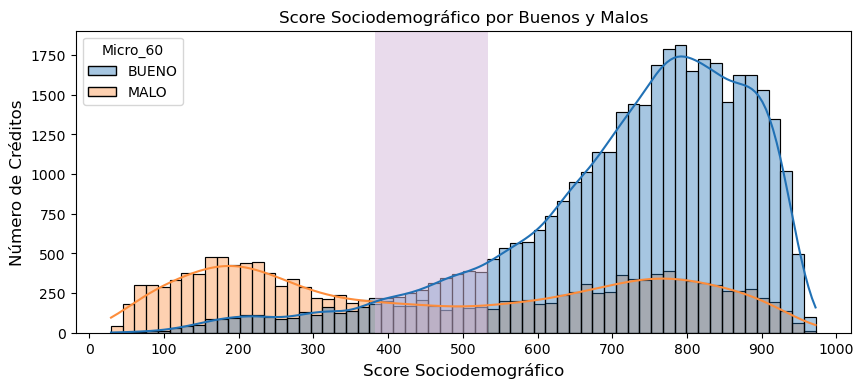

In [105]:
fig, ax =plt.subplots(figsize=(10,4), dpi=100)
palette = {"BUENO":"#2171b5","MALO":"#fd8d3c", "NUEVO":"#74c476"}
sns.histplot(data = df_cliente,x = 'Score_Buenos',alpha = .4,hue = 'Micro_60',kde=True ,  palette = palette)
label=('Score Socio Demografico - (IRB)')
ax.set_xlabel('Score Sociodemográfico', fontsize=12)
ax.set_ylabel('Número de Créditos', fontsize=12)
ax.set_title('Score Sociodemográfico por Buenos y Malos', fontsize=12)
ax.set_xticks([0,100,200,300,400,500,600,700,800,900,1000])
#plt.legend(loc='upper left')
ax.axvspan(382, 533, facecolor='#d4b9da', alpha=0.5)
#ax.axvspan(440, 533, facecolor='#bdbdbd', alpha=0.5)
plt.show()

In [106]:
df_cliente.groupby(['Bucket','Micro_60'],as_index = False).count().pivot('Bucket','Micro_60').fillna(0)

ente       CEDULA       nro_operacion       fecha_contabilizacion  \
Micro_60 BUENO  MALO  BUENO  MALO         BUENO  MALO                 BUENO   
Bucket                                                                        
0.0        128  1955    128  1955           128  1955                   128   
0.1       1114  4082   1114  4082          1114  4082                  1114   
0.2       1938  1836   1938  1836          1938  1836                  1938   
0.3       2817  1099   2817  1099          2817  1099                  2817   
0.4       4351  1284   4351  1284          4351  1284                  4351   
0.5       5808  1404   5808  1404          5808  1404                  5808   
0.6       5811  1249   5811  1249          5811  1249                  5811   
0.7       5181   965   5181   965          5181   965                  5181   
0.8       4378   791   4378   791          4378   791                  4378   
0.9       4651   658   4651   658          4651   658                  4651   
1.0        972   137    972   137           972   137                   972   

                 mes        anio       porcentaje_cancelacion        \
Micro_60  MALO BUENO  MALO BUENO  MALO                  BUENO  MALO   
Bucket                                                                
0.0       1955   128  1955   128  1955                    128  1955   
0.1       4082  1114  4082  1114  4082                   1114  4082   
0.2       1836  1938  1836  1938  1836                   1938  1836   
0.3       1099  2817  1099  2817  1099                   2817  1099   
0.4       1284  4351  1284  4351  1284                   4351  1284   
0.5       1404  5808  1404  5808  1404                   5808  1404   
0.6       1249  5811  1249  5811  1249                   5811  1249   
0.7        965  5181   965  5181   965                   5181   965   
0.8        791  4378   791  4378   791                   4378   791   
0.9        658  4651   658  4651   658                   4651   658   
1.0        137   972   137   972   137                    972   137   

         porcentaje_cancelacion_saldo       Constante       cliente_nuevo  \
Micro_60                        BUENO  MALO     BUENO  MALO         BUENO   
Bucket                                                                      
0.0                               128  1955       128  1955           128   
0.1                              1114  4082      1114  4082          1114   
0.2                              1938  1836      1938  1836          1938   
0.3                              2817  1099      2817  1099          2817   
0.4                              4351  1284      4351  1284          4351   
0.5                              5808  1404      5808  1404          5808   
0.6                              5811  1249      5811  1249          5810   
0.7                              5181   965      5181   965          5179   
0.8                              4378   791      4378   791          4378   
0.9                              4651   658      4651   658          4651   
1.0                               972   137       972   137           972   

               des_estado_civil       des_sector       des_op_sector_bnf  \
Micro_60  MALO            BUENO  MALO      BUENO  MALO             BUENO   
Bucket                                                                     
0.0       1955              128  1955        128  1954               128   
0.1       4082             1114  4082       1114  4080              1113   
0.2       1836             1938  1836       1938  1836              1938   
0.3       1099             2817  1099       2817  1099              2814   
0.4       1284             4351  1284       4351  1284              4350   
0.5       1404             5808  1404       5808  1404              5807   
0.6       1249             5811  1249       5810  1249              5811   
0.7        965             5181   965       5180   965              5

In [107]:
kstable_1 = pd.DataFrame.pivot_table(df_cliente, values ='CEDULA', index =['Bucket'],columns =['Micro_60'], aggfunc = np.count_nonzero)
kstable_1

Micro_60  BUENO  MALO
Bucket               
0.0         128  1955
0.1        1114  4082
0.2        1938  1836
0.3        2817  1099
0.4        4351  1284
0.5        5808  1404
0.6        5811  1249
0.7        5181   965
0.8        4378   791
0.9        4651   658
1.0         972   137

In [108]:
def acu_sum(x):
    LISTA_RPUEBA=list(x)
    vector=[LISTA_RPUEBA[i] if i==0 else LISTA_RPUEBA[i]+LISTA_RPUEBA[i-1]
                       for i in range(0,len(LISTA_RPUEBA))]
    return vector

In [109]:
def decu_sum(x):
    LISTA_RPUEBA=list(x)
    vector=[LISTA_RPUEBA[i] if i==0 else LISTA_RPUEBA[i]-LISTA_RPUEBA[i-1]
                       for i in range(0,len(LISTA_RPUEBA))]
    return vector

In [110]:
kstable = pd.DataFrame.pivot_table(df_cliente, values ='CEDULA', index =['rango'],columns =['Micro_60'], aggfunc = np.count_nonzero)
kstable.reset_index(inplace = True)
#kstable.index = range(1,11)
#kstable.index.rename('Decile', inplace=True)
kstable

Micro_60           rango  BUENO  MALO
0         (3.999, 231.0]    641  4406
1         (231.0, 401.0]   1474  2721
2         (401.0, 522.0]   2397  1316
3         (522.0, 619.0]   3377  1129
4         (619.0, 702.0]   5282  1361
5         (702.0, 766.0]   5988  1403
6         (766.0, 816.0]   5564  1134
7         (816.0, 860.0]   4596   815
8         (860.0, 908.0]   4785   755
9         (908.0, 979.0]   3045   420

In [111]:
kstable.insert(0,'DECIL',int,allow_duplicates=False)
kstable['DECIL'] = np.arange(0,10)+1
kstable.insert(2,'TOT_POB',int,allow_duplicates=False)
kstable['TOT_POB'] = (kstable['BUENO'])+(kstable['MALO'])
kstable.insert(3,'DIST_POB',int,allow_duplicates=False)
kstable['DIST_POB'] = np.round((kstable['TOT_POB']/kstable['TOT_POB'].sum()),3)
kstable.insert(4,'DIST_POB_ACUM',int,allow_duplicates=False)
kstable['DIST_POB_ACUM'] = kstable['DIST_POB'].cumsum()
kstable.insert(6,'B_ACUM',int,allow_duplicates=False)
kstable['B_ACUM'] = (kstable['BUENO'].cumsum())
kstable.insert(7,'DIST_B_ACUM',int,allow_duplicates=False)
kstable['DIST_B_ACUM'] =  np.round((kstable['B_ACUM']/kstable['BUENO'].sum()),3)
kstable.insert(8,'TASA_B_ACUM',int,allow_duplicates=False)
kstable['TASA_B_ACUM']=np.round(acu_sum(kstable['DIST_B_ACUM']),3)
kstable.insert(10,'M_ACUM',int,allow_duplicates=False)
kstable['M_ACUM'] = (kstable['MALO'].cumsum())
kstable.insert(11,'DIST_M_ACUM',int,allow_duplicates=False)
kstable['DIST_M_ACUM'] =  np.round((kstable['M_ACUM']/kstable['MALO'].sum()),3)
kstable.insert(12,'TASA_M_ACUM',int,allow_duplicates=False)
kstable['TASA_M_ACUM'] = np.round(decu_sum(kstable['DIST_M_ACUM']),3)
kstable.insert(13,'ODDS',int,allow_duplicates=False)
kstable['ODDS'] = np.round(kstable['BUENO'].divide(kstable['MALO']),decimals=2).apply(np.floor)
kstable.insert(14,'M_B',int,allow_duplicates=False)
kstable['M_B'] = np.round(kstable['MALO'].divide(kstable['BUENO']),3)
kstable.insert(15,'TASA_M',int,allow_duplicates=False)
kstable['TASA_M'] = np.round(kstable['MALO'].divide(kstable['TOT_POB']),3)
kstable.insert(16,'PERDIDA',int,allow_duplicates=False)
kstable['PERDIDA'] = np.round((kstable['DIST_POB_ACUM'])*(kstable['TASA_M']),3)
kstable.insert(17,'PERDIDA_ACUM',int,allow_duplicates=False)
kstable['PERDIDA_ACUM'] = np.round(kstable['PERDIDA'].cumsum(),3)
kstable.insert(18,'GINI',int,allow_duplicates=False)
kstable['GINI'] = np.round((kstable['TASA_B_ACUM'])*(kstable['TASA_M_ACUM']),3)
kstable.insert(19,'KS',int,allow_duplicates=False)
kstable['KS'] = np.round(kstable['DIST_M_ACUM']-kstable['DIST_B_ACUM'],4)
kstable.insert(20,'TPR',int,allow_duplicates=False)
kstable['TPR'] = np.round(1-(kstable['M_ACUM']/kstable['M_ACUM'].max()),3)
kstable.insert(21,'FPR',int,allow_duplicates=False)
kstable['FPR'] = np.round(1-(kstable['B_ACUM']/kstable['B_ACUM'].max()),3)
kstable.insert(22,'AUC',int,allow_duplicates=False)
kstable['AUC'] = np.round((np.abs(kstable['FPR'].diff(+1)))*(kstable['TPR'].rolling(2).mean()),3)

Micro_60  DECIL           rango  TOT_POB  DIST_POB  DIST_POB_ACUM  BUENO  \
0             1  (3.999, 231.0]     5047     0.096          0.096    641   
1             2  (231.0, 401.0]     4195     0.080          0.176   1474   
2             3  (401.0, 522.0]     3713     0.071          0.247   2397   
3             4  (522.0, 619.0]     4506     0.086          0.333   3377   
4             5  (619.0, 702.0]     6643     0.126          0.459   5282   
5             6  (702.0, 766.0]     7391     0.140          0.599   5988   
6             7  (766.0, 816.0]     6698     0.127          0.726   5564   
7             8  (816.0, 860.0]     5411     0.103          0.829   4596   
8             9  (860.0, 908.0]     5540     0.105          0.934   4785   
9            10  (908.0, 979.0]     3465     0.066          1.000   3045   

Micro_60  B_ACUM  DIST_B_ACUM  TASA_B_ACUM  MALO  M_ACUM  DIST_M_ACUM  \
0            641        0.017        0.017  4406    4406        0.285   
1           2115        0.057        0.074  2721    7127        0.461   
2           4512        0.121        0.178  1316    8443        0.546   
3           7889        0.212        0.333  1129    9572        0.619   
4          13171        0.355        0.567  1361   10933        0.707   
5          19159        0.516        0.871  1403   12336        0.798   
6          24723        0.666        1.182  1134   13470        0.871   
7          29319        0.789        1.455   815   14285        0.924   
8          34104        0.918        1.707   755   15040        0.973   
9          37149        1.000        1.918   420   15460        1.000   

Micro_60  TASA_M_ACUM  ODDS    M_B  TASA_M  PERDIDA  PERDIDA_ACUM   GINI  \
0               0.285   0.0  6.874   0.873    0.084         0.084  0.005   
1               0.176   0.0  1.846   0.649    0.114         0.198  0.013   
2               0.085   1.0  0.549   0.354    0.087         0.285  0.015   
3               0.073   2.0  0.334   0.251    0.084         0.369  0.024   
4               0.088   3.0  0.258   0.205    0.094         0.463  0.050   
5               0.091   4.0  0.234   0.190    0.114         0.577  0.079   
6               0.073   4.0  0.204   0.169    0.123         0.700  0.086   
7               0.053   5.0  0.177   0.151    0.125         0.825  0.077   
8               0.049   6.0  0.158   0.136    0.127         0.952  0.084   
9               0.027   7.0  0.138   0.121    0.121         1.073  0.052   

Micro_60     KS    TPR    FPR    AUC  
0         0.268  0.715  0.983    NaN  
1         0.404  0.539  0.943  0.025  
2         0.425  0.454  0.879  0.032  
3         0.407  0.381  0.788  0.038  
4         0.352  0.293  0.645  0.048  
5         0.282  0.202  0.484  0.040  
6         0.205  0.129  0.334  0.025  
7         0.135  0.076  0.211  0.013  
8         0.055  0.027  0.082  0.007  
9         0.000  0.000  0.000  0.001

In [ ]:
a = (1-kstable['FPR'][0])

In [ ]:
TPR_list = kstable['TPR'].values.tolist()
TPR_list.insert(0,1)
TPR_list = pandas.DataFrame(TPR_list,columns=['TPR_list'])

In [ ]:
TPR_list_M = TPR_list.rolling(2).mean()
b=TPR_list_M.loc[1,:]

In [ ]:
kstable['AUC'][0] = a*b

In [ ]:
kstable

# KPIS

In [112]:
from colorama import Fore
print(Fore.RED + "KS is " + str(max(kstable['KS']))+" "+ "at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))

KS is 0.425 at decile 2


In [113]:
Gini = 1-kstable.loc[:, 'GINI'].sum()
print(Fore.BLUE + "Gini is " +str(1-kstable.loc[:, 'GINI'].sum()) + " " )

Gini is 0.515 


In [114]:
AUC = 1-kstable.loc[:, 'AUC'].sum()
print(Fore.GREEN + "AUC is " +str(1-kstable.loc[:, 'AUC'].sum()) + " " )

AUC is 0.771 


In [115]:
kstable.to_excel("BKT_30122021.xlsx",sheet_name='ks')

<Figure size 432x288 with 0 Axes>

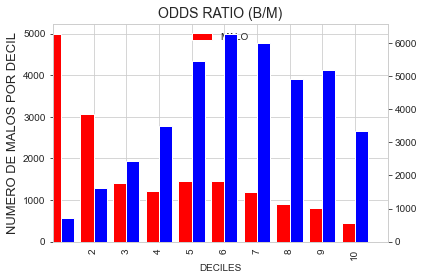

In [93]:
sns.set_style("whitegrid")
df= kstable

fig,  plt.figure(figsize=(8,4), dpi=100)
ax = df.plot(kind ='bar', x="DECIL", y='MALO', legend=False,  color="r", width=0.4, position=1)
ax2 = ax.twinx()
df.plot(kind ='bar',x="DECIL", y='BUENO', ax=ax2, legend=False, color="b", width=0.4, position=0)
#df.plot(kind ='line',x="DECIL", y='M_B', ax=ax2, legend=False, color="r")
#ax.figure.legend()
#plt.plot([1, 10], [1, 10],'r--')
#plt.xlim([0, 1.0])
#plt.ylim([0, 1.0])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
plt.grid()
ax.set_xlabel('DECILES', fontsize = 12)
ax.set_ylabel('NUMERO DE MALOS POR DECIL', fontsize = 12)
ax.set_title('NÚMERO DE MALOS', fontsize = 14)
#ax.legend(frameon=False, loc='upper center')
plt.show()

<Figure size 432x288 with 0 Axes>

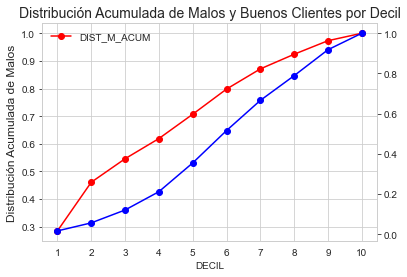

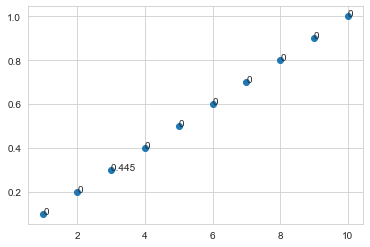

In [116]:
sns.set_style("whitegrid")
df= kstable
fig,  plt.figure(figsize=(8,4), dpi=100)
ax = df.plot(x="DECIL", y='DIST_M_ACUM', legend=False,  color="r", marker='o')
ax2 = ax.twinx()
df.plot(x="DECIL", y='DIST_B_ACUM', ax=ax2, legend=False, color="b", marker='o')
#ax.figure.legend()
#plt.plot([1, 10], [1, 10],'r--')
#plt.xlim([0, 1.0])
#plt.ylim([0, 1.0])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
plt.grid()
ax.set_xlabel('DECIL', fontsize = 12)
ax.set_ylabel('Distribución Acumulada de Malos', fontsize = 12)
ax.set_title('Distribución Acumulada de Malos y Buenos Clientes por Decil', fontsize = 14)
ax.legend(frameon=False, loc='upper left', ncol=1)

#y = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
#x = [1,2,3,4,5,6,7,8,9,10]
#n = [0,0,0.4450,0,0,0,0,0,0,0]
 
#fig, ax = plt.subplots()
#ax.scatter(x, y)
 
#for i, txt in enumerate(n):
#    ax.annotate(txt, (x[i], y[i]))
    
 
plt.text(4,0.5, 'KS = 0.', fontsize = 12) 
plt.show()

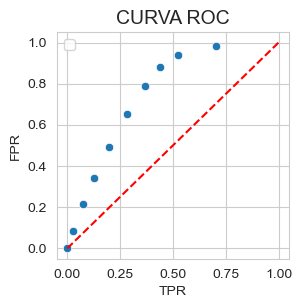

In [94]:
fig, ax =  plt.subplots(figsize=(5,4), dpi=100)
sns.scatterplot(data=kstable, y='FPR', x='TPR')
#sns.scatterplot(data=kstable, x=('DECIL'), y=('DECIL'))
#plt.plot('FPR', 'TPR', label='Logistic Regression (area = %0.2f)' %)
ax.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

plt.plot([0.0, 1], [0.0, 1],'r--')
#plt.legend()
#plt.xlim(0,35000)
plt.title('CURVA ROC', fontsize = 14)
#ax.set_xlabel('TRUE POSITIVE RATE', fontsize = 12)
#ax.set_ylabel('FAKE POSITVE RATE', fontsize = 12)
plt.text(0.2,0.5, 'AUC = 0.')  
plt.show()

<Figure size 432x288 with 0 Axes>

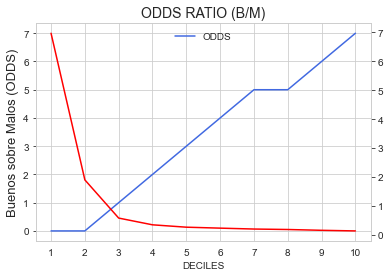

In [92]:
sns.set_style("whitegrid")
df= kstable
fig = plt.figure()
ax = df.plot(kind ='line', x="DECIL", y='ODDS', legend=False,  color="royalblue")
ax2 = ax.twinx()
df.plot(kind ='line',x="DECIL", y='M_B', ax=ax2, legend=False, color="r")
#ax.figure.legend()
#plt.plot([1, 10], [1, 10],'r--')
#plt.xlim([0, 1.0])
#plt.ylim([0, 1.0])
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
plt.grid()
ax.set_xlabel('DECILES')
ax.set_ylabel('Buenos sobre Malos (ODDS)', fontsize = 13)
ax.set_title('ODDS RATIO (B/M)', fontsize = 14)
ax.legend(frameon=False, loc='upper center', ncol=2)
plt.show()

# Arboles de Decisión 

In [269]:
df_cliente = pd.read_csv('Base_Score_Test_30092021.txt', sep='~', header='infer',  encoding = 'ISO-8859-1', error_bad_lines=True, low_memory=False)
df_cliente.head(2)

ente     CEDULA  nro_operacion    fecha_contabilizacion  mes  anio  \
0   426122.0  100006550      510035898  2016-05-03 00:00:00.000    5  2016   
1  2509294.0  100009406      440018580  2016-03-09 00:00:00.000    3  2016   

   porcentaje_cancelacion  porcentaje_cancelacion_saldo  Constante  \
0                    0.00                          0.00  -2.480754   
1                    0.87                          0.87  -2.480754   

   cliente_nuevo des_estado_civil     des_sector des_op_sector_bnf  \
0            0.0           CASADO  SECTOR URBANO          PECUARIO   
1            0.0           CASADO  SECTOR URBANO          AGRICOLA   

      des_zonal des_forma_pago   ing_gas  activos_pasivos  \
0  ZONAL CUENCA          ANUAL  6.421077         0.000000   
1  ZONAL CUENCA      SEMESTRAL  2.641717       198.666667   

   CUOTA_ESTIMADA_BURO  ENDEUDAMIENTO_PROMEDIO  ventas_netas_balances  \
0               783.96                  0.0000                81300.0   
1               332.46                895.4533                 3300.0   

   monto_aprobado  SUELDO  periodos_plazo  PLAZO_MESES  \
0         15000.0  2000.0               2         24.0   
1          3000.0  1000.0               8         48.0   

   mayorplazovencidohistóricototal  Var1  Var2      Var3      Var4      var5  \
0                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   
1                              0.0   0.0   0.0  0.291455 -0.449455 -0.139981   

       var6      var7      var8      var9     var10     var11     var12  \
0 -0.298471 -0.327237  0.008148  0.000000  1.103768  0.000000  0.080233   
1 -0.252034 -0.327237  0.008148  0.257294  0.070112  0.039883 -0.159057   

      var13     var14     var15  var16  log_odds  P_malos  Score_Malos  \
0  0.044626 -0.256356  0.611717    0.0 -1.812307  0.14036   140.359502   
1  0.000000  0.000000  0.524902    0.0 -2.616724  0.06807    68.069790   

   Score_Buenos trim(base_scoring.Micro_60)  score_buro  peor_calificacion  
0           860                       BUENO       958.0                1.0  
1           932                       BUENO       947.0                3.0

In [270]:
df_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729973 entries, 0 to 729972
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ente                             729966 non-null  float64
 1   CEDULA                           729973 non-null  int64  
 2   nro_operacion                    729973 non-null  int64  
 3   fecha_contabilizacion            729973 non-null  object 
 4   mes                              729973 non-null  int64  
 5   anio                             729973 non-null  int64  
 6   porcentaje_cancelacion           729973 non-null  float64
 7   porcentaje_cancelacion_saldo     729973 non-null  float64
 8   Constante                        729973 non-null  float64
 9   cliente_nuevo                    728142 non-null  float64
 10  des_estado_civil                 729963 non-null  object 
 11  des_sector                       729494 non-null  object 
 12  de

In [241]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import tree
import matplotlib.pyplot as plt
# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [242]:
df_cliente.head(3)

ente      CEDULA  nro_operacion fecha_creacion  mes  anio  Constante  \
0   880016  1311759706        2915663     2021-12-08   12  2021  -2.480754   
1   125675  1313131581        2901704     2021-10-26   10  2021  -2.480754   
2  1174925  1715667836        2913536     2021-12-01   12  2021  -2.480754   

   cliente_nuevo_buro des_estado_civil     des_sector  des_op_sector_bnf  \
0                   0          SOLTERO  SECTOR URBANO  PEQUEÑA INDUSTRIA   
1                   0          SOLTERO  SECTOR URBANO          SERVICIOS   
2                   0          SOLTERO  SECTOR URBANO          ARTESANAL   

          des_zonal des_forma_pago   ing_gas  activos_pasivos  \
0  ZONAL PORTOVIEJO        MENSUAL  2.300532        13.329615   
1   ZONAL GUAYAQUIL        MENSUAL  1.461538         2.981256   
2  ZONAL PORTOVIEJO        MENSUAL  2.747253        14.568972   

   CUOTA_ESTIMADA_BURO  ENDEUDAMIENTO_PROMEDIO  ventas_netas_balances  \
0                 0.00                     0.0                 3500.0   
1                81.83                     0.0                  450.0   
2                 0.00                     0.0                 2000.0   

   monto_aprobado  SUELDO  periodos_plazo  PLAZO_MESES  \
0        10000.00  2000.0              36           36   
1         3595.81   750.0              60           60   
2        10000.00  3000.0              36           36   

   mayorplazovencidohistóricototal  Var1      Var2      Var3      Var4  \
0                                5   0.0  0.132448  0.291455 -0.240017   
1                                5   0.0  0.132448  0.291455  0.000000   
2                                3   0.0  0.132448  0.291455 -0.276056   

       var5      var6      var7      var8      var9     var10     var11  \
0  0.620280 -0.101578 -0.327237  0.000000  0.490615  1.103768  0.039883   
1  0.305646 -0.101578 -0.327237  0.319766  0.490615  1.103768  0.175720   
2  0.620280 -0.101578 -0.327237  0.000000  0.490615  1.103768  0.035600   

      var12     var13     var14     var15     var16  log_odds   P_malos  \
0  0.000000  0.044626  0.337383  0.692077  2.219912  2.822860  0.943899   
1 -0.233529  0.051385  0.337383  0.524902  2.219912  2.809901  0.943209   
2  0.000000  0.044626  0.337383  0.692077  2.219912  2.782538  0.941725   

   Score_Malos  Score_Buenos  percentile   score_buro peor_calificacion  \
0   943.898730            56          1.0       777.0                A1   
1   943.208519            57          1.0        17.0                 E   
2   941.724906            58          1.0         NaN                A3   

  Micro_60_pronosticado Micro_60  P_buenos       ODDS  ODDS_ODDS_1         p  \
0                  MALO    BUENO  0.056101  16.824909     0.943899  0.943899   
1                  MALO     MALO  0.056791  16.608275     0.943209  0.943209   
2                  MALO     MALO  0.058275  16.159989     0.941725  0.941725   

         p1 Micro_60_predecidos  
0  0.943899              MALO_P  
1  0.943209              MALO_P  
2  0.941725              MALO_P

In [272]:
df_cliente.shape

(729973, 48)

In [274]:
df_cliente.rename(columns = {'trim(base_scoring.Micro_60)':'Micro_60'}, inplace = True)
df_cliente.rename(columns = {'mayorplazovencidohist�ricototal':'mpvht'}, inplace = True)

In [275]:
df_cliente['TARGET'] = df_cliente['Micro_60'].map({'BUENO': 0, 'MALO': 1})

In [276]:
df_c=  pd.DataFrame()
df_c['TARGET']=df_cliente['TARGET'].values
df_c['PLAZO_MESES']=df_cliente['PLAZO_MESES'].values
df_c['MONTO']=df_cliente['monto_aprobado'].values
df_c['Score_Buenos']=df_cliente['Score_Buenos'].values
df_c['score_buro']=df_cliente['score_buro'].values

In [277]:
df_c.head(2)

TARGET  PLAZO_MESES    MONTO  Score_Buenos  score_buro
0       0         24.0  15000.0           860       958.0
1       0         48.0   3000.0           932       947.0

In [278]:
df_c.describe(percentiles = [0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9])

TARGET    PLAZO_MESES          MONTO   Score_Buenos  \
count  729973.000000  729971.000000  729973.000000  729973.000000   
mean        0.325542      38.942335    6726.384839     627.944394   
std         0.468577      21.783437    5267.303847     254.074475   
min         0.000000       0.000000       1.590000       4.000000   
10%         0.000000      12.000000    2000.000000     213.000000   
20%         0.000000      24.000000    2922.900000     367.000000   
25%         0.000000      24.000000    3000.000000     445.000000   
30%         0.000000      24.000000    3107.570000     511.000000   
40%         0.000000      36.000000    4298.560000     623.000000   
50%         0.000000      36.000000    5000.000000     706.000000   
60%         0.000000      40.000000    6000.000000     766.000000   
70%         1.000000      48.000000    8000.000000     815.000000   
75%         1.000000      60.000000   10000.000000     838.000000   
80%         1.000000      60.000000   10000.000000     860.000000   
90%         1.000000      64.000000   15000.000000     906.000000   
max         1.000000     720.000000  232393.070000     979.000000   

          score_buro  
count  377902.000000  
mean      743.994649  
std       276.921817  
min         0.000000  
10%       243.000000  
20%       528.000000  
25%       646.000000  
30%       688.000000  
40%       813.000000  
50%       898.000000  
60%       926.000000  
70%       941.000000  
75%       947.000000  
80%       949.000000  
90%       952.000000  
max       999.000000

In [247]:
for column in ['TARGET','PLAZO_MESES', 'MONTO','Score_Buenos','score_buro']:
    df_c[column].fillna(df_c[column].mode()[0], inplace=True)

In [248]:
df = df_c

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4989 entries, 0 to 4988
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TARGET        4989 non-null   float64
 1   PLAZO_MESES   4989 non-null   int64  
 2   MONTO         4989 non-null   float64
 3   Score_Buenos  4989 non-null   int64  
 4   score_buro    4989 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 195.0 KB


In [280]:
modelo_1 = DecisionTreeRegressor(max_depth =3,random_state = 0)
y_train = df['TARGET'] 
X_train = df.loc[:,['Score_Buenos']]
modelo_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [281]:
X_train.shape

(4989, 1)

In [254]:
## Convertidor Online del archivo dot generado 
## https://dreampuf.github.io/GraphvizOnline/#digraph%20G%20%7B%0A%0A%20%20subgraph%20cluster_0%20%7B%0A%20%20%20%20style%3Dfilled%3B%0A%20%20%20%20color%3Dlightgrey%3B%0A%20%20%20%20node%20%5Bstyle%3Dfilled%2Ccolor%3Dwhite%5D%3B%0A%20%20%20%20a0%20-%3E%20a1%20-%3E%20a2%20-%3E%20a3%3B%0A%20%20%20%20label%20%3D%20%22process%20%231%22%3B%0A%20%20%7D%0A%0A%20%20subgraph%20cluster_1%20%7B%0A%20%20%20%20node%20%5Bstyle%3Dfilled%5D%3B%0A%20%20%20%20b0%20-%3E%20b1%20-%3E%20b2%20-%3E%20b3%3B%0A%20%20%20%20label%20%3D%20%22process%20%232%22%3B%0A%20%20%20%20color%3Dblue%0A%20%20%7D%0A%20%20start%20-%3E%20a0%3B%0A%20%20start%20-%3E%20b0%3B%0A%20%20a1%20-%3E%20b3%3B%0A%20%20b2%20-%3E%20a3%3B%0A%20%20a3%20-%3E%20a0%3B%0A%20%20a3%20-%3E%20end%3B%0A%20%20b3%20-%3E%20end%3B%0A%0A%20%20start%20%5Bshape%3DMdiamond%5D%3B%0A%20%20end%20%5Bshape%3DMsquare%5D%3B%0A%7D

tree.export_graphviz(modelo_1,
                     out_file="tree.dot",
                     feature_names = 'Score_Buenos', 
                     class_names=cn,
                     filled = True)

ValueError: Length of feature_names, 12 does not match number of features, 1

Profundidad del árbol: 3
Número de nodos terminales: 8


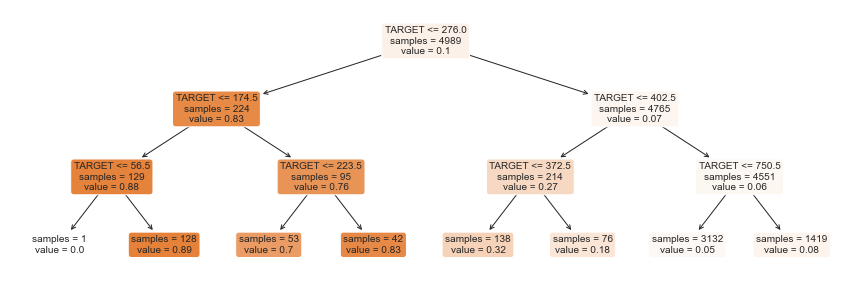

In [282]:
fig, ax = plt.subplots(figsize=(15, 5))
tree.plot_tree(modelo_1, fontsize=15)
print(f"Profundidad del árbol: {modelo_1.get_depth()}")
print(f"Número de nodos terminales: {modelo_1.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo_1,
            feature_names = df.columns,
            class_names   = 'TARGET',
            filled        = True,
            rounded       = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax)
plt.show()

[Text(167.4, 190.26, 'X[0] <= 276.0\nsquared_error = 0.09\nsamples = 4989\nvalue = 0.1'),
 Text(83.7, 135.9, 'X[0] <= 174.5\nsquared_error = 0.141\nsamples = 224\nvalue = 0.83'),
 Text(41.85, 81.53999999999999, 'X[0] <= 56.5\nsquared_error = 0.103\nsamples = 129\nvalue = 0.884'),
 Text(20.925, 27.180000000000007, 'squared_error = 0.0\nsamples = 1\nvalue = 0.0'),
 Text(62.775000000000006, 27.180000000000007, 'squared_error = 0.097\nsamples = 128\nvalue = 0.891'),
 Text(125.55000000000001, 81.53999999999999, 'X[0] <= 223.5\nsquared_error = 0.183\nsamples = 95\nvalue = 0.758'),
 Text(104.625, 27.180000000000007, 'squared_error = 0.211\nsamples = 53\nvalue = 0.698'),
 Text(146.475, 27.180000000000007, 'squared_error = 0.139\nsamples = 42\nvalue = 0.833'),
 Text(251.10000000000002, 135.9, 'X[0] <= 402.5\nsquared_error = 0.062\nsamples = 4765\nvalue = 0.066'),
 Text(209.25, 81.53999999999999, 'X[0] <= 372.5\nsquared_error = 0.198\nsamples = 214\nvalue = 0.271'),
 Text(188.32500000000002, 27.

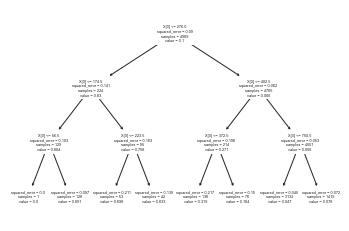

In [256]:
tree.plot_tree(modelo_1)

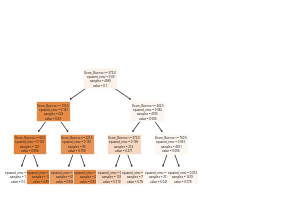

In [257]:
fn=['Score_Buenos']
cn=['TARGET']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (7,5), dpi=50)
tree.plot_tree(modelo_1, feature_names = fn, class_names=cn,filled = True);
fig.savefig('PERFILES.png')

In [258]:
from sklearn import tree
from dtreeviz.trees import *
import graphviz 
import warnings
warnings.filterwarnings("ignore") 

In [263]:
features = df.loc[:,['MONTO','PLAZO_MESES','score_buro']]
target = df['TARGET']

In [266]:
features.describe()

MONTO  PLAZO_MESES   score_buro
count    4989.000000  4989.000000  4989.000000
mean     7470.310375    23.167569   884.206053
std      9284.046216    23.777571   151.393667
min       300.000000     1.000000    12.000000
25%      3000.000000     4.000000   920.000000
50%      5000.000000    12.000000   945.000000
75%     10000.000000    36.000000   945.000000
max    150000.000000   180.000000   993.000000

In [264]:
fig = plt.figure(figsize=(25,20))
regr= tree.DecisionTreeRegressor(max_depth=4)  
regr.fit(features, target)
viz = dtreeviz(regr,
               features,
               target,
               target_name='TARGET',
               feature_names=features.columns,
               title="Perfiles regression",
               fontname="Arial",
               colors = {"title":"purple"},
               scale=1.5)
viz

<Figure size 1800x1440 with 0 Axes>

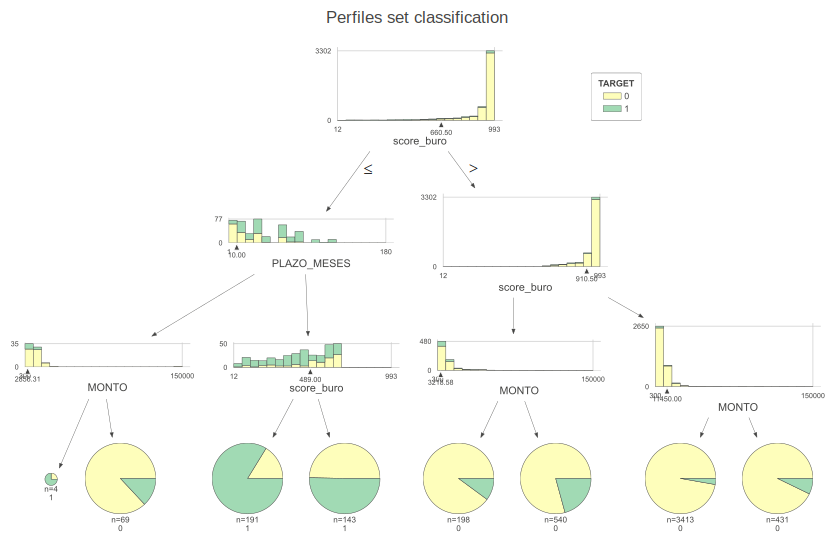

<Figure size 1800x1440 with 0 Axes>

In [279]:
fig = plt.figure(figsize=(25,20))
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(features, target)
# pick random X observation for demo
#X = wine.data[np.random.randint(0, len(wine.data)),:]
viz = dtreeviz(clf,
               features,
               target,
               target_name='TARGET',
               feature_names=features.columns,
               title="Perfiles set classification",
               class_names=['0', '1'],
               histtype='barstacked', # default 
               scale=1.2)
viz

In [93]:
total = kstable.sum()
total.name = 'Total'
# Assign sum of all rows of DataFrame as a new Row
kstable = kstable.append(total.transpose())

In [94]:
cols = [0]
kstable.drop(kstable.columns[cols], axis=1, inplace=True)

In [95]:
kstable['MALOS_ACUM'] = (kstable['MALO'].cumsum())
kstable['TASA_MALOS_ACUM'] = (kstable['MALOS_ACUM']/kstable['MALOS_ACUM'].sum()).apply('{0:.2%}'.format)

In [96]:
    kstable['TASA_MALOS'] = (kstable.MALO  / df_cliente['MALO'].sum()).apply('{0:.2%}'.format)
    kstable['TASA_BUENOS'] = (kstable.BUENO / df_cliente['BUENO'].sum()).apply('{0:.2%}'.format)

In [97]:
data= df_cliente
def ks(data=None,target=None, prob=None):
    data['BUENO'] = 1 - data['MALO']
    data['bucket'] = pd.qcut(data['Score_Buenos'], 9)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['P_buenos']
    kstable['max_prob'] = grouped.max()['P_buenos']
    kstable['MALO']   = grouped.sum()['MALO']
    kstable['BUENO'] = grouped.sum()['BUENO']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['TASA_MALOS'] = ( kstable['MALO']  / data['MALO'].sum()).apply('{0:.2%}'.format)
    kstable['TASA_BUENOS'] = ( kstable['BUENO']/ data['BUENOS'].sum()).apply('{0:.2%}'.format)
    kstable['TASA_MALOS_ACUM']=(kstable['MALO'] / data['MALO'].sum()).cumsum()
    kstable['TASA_BUENOS_ACUM']=(kstable['BUENO'] / data['BUENOS'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['TASA_MALOS_ACUM']-kstable['TASA_BUENOS_ACUM'], 3) * 100

    #Formating
    kstable['TASA_MALOS_ACUM']= kstable['TASA_MALOS_ACUM'].apply('{0:.2%}'.format)
    kstable['TASA_BUENOS_ACUM']= kstable['TASA_BUENOS_ACUM'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [98]:
ks

<function __main__.ks(data=None, target=None, prob=None)>

In [99]:
data= df_cliente
def ks(data=None,target=None, prob=None):
    data['bucket'] = pd.qcut(data['Score_Buenos'], 9)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['P_buenos']
    kstable['max_prob'] = grouped.max()['P_buenos']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)

In [100]:
mydf = ks(data=df_cliente,target="MALO", prob="P_buenos")

(array([ 40.,  49.,  61.,  43.,  32.,  55.,  82., 124., 159., 177., 278.,
        353., 583., 652., 656., 538., 494., 431., 170.,  12.]),
 array([ 56.  , 101.25, 146.5 , 191.75, 237.  , 282.25, 327.5 , 372.75,
        418.  , 463.25, 508.5 , 553.75, 599.  , 644.25, 689.5 , 734.75,
        780.  , 825.25, 870.5 , 915.75, 961.  ]),
 <BarContainer object of 20 artists>)

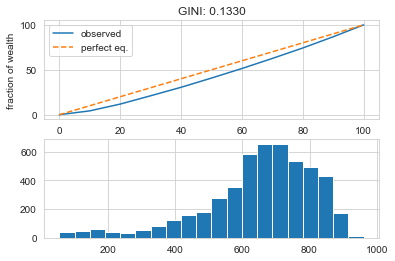

In [101]:
def G(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

v = df_cliente['Score_Buenos']
bins, result, gini_val = G(v)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("fraction of population")
plt.ylabel("fraction of wealth")
plt.title("GINI: %.4f" %(gini_val))
plt.legend()
plt.subplot(2, 1, 2)
plt.hist(v, bins=20)

In [ ]:
G(df_cliente['Score_Buenos'])